# Fine Tuning Transformers for identification of Human Values behind Arguments

### Introduction

In this notebook we will be fine tuning different transformer models
for the **detection of human values** given a specifc argument. It consists of a **Multilabel text classification** problem where a given piece of text needs to be classified into one or more categories out of the given list. For example, as in this case, a given argument can be categorized into 1 or more human values.

#### Flow of the notebook

The notebook will be divided into seperate sections to provide a organized walk through for the process used. The sections are:

1. [Importing Python Libraries and preparing the environment](#section01)
2. [Importing and Pre-Processing the domain data](#section02)
3. [Preparing the Dataset and Dataloader](#section03)
4. [Creating the Neural Network for Fine Tuning](#section04)
5. [Fine Tuning the Model](#section05)
6. [Validating the Model Performance](#section06)
7. [Evaluating the best model](#section07)
8. [Choosing the best threshold](#section08)
9. [Results](#section09)

#### Technical Details

 - Data: 
	 - We are using the data available on [Zenodo](https://zenodo.org/record/7550385#.Y8wMquzMK3I)
     - [Human Value Detection 2023](https://touche.webis.de/semeval23/touche23-web/index.html) is the competion which provide the souce dataset
	 - We are referring only to the following data: `arguments-training.tsv`, `arguments-validation`, `labels-training.tsv`, `labels-validation.tsv`
	 
     - `arguments-<split>.tsv`: Each row corresponds to one argument
        - `Argument ID`: The unique identifier for the argument
        - `Conclusion`: Conclusion text of the argument
        - `Stance`: Stance of the Premise towards the Conclusion; one of "in favor of", "against"
        - `Premise`: Premise text of the argument

     - `labels-<split>.tsv`: Each row corresponds to one argument
        - `Argument ID`: The unique identifier for the argument
        - `Other`: Each other column corresponds to one value category, with a 1 meaning that the argument resorts to the value category and a 0 that not
---
***NOTE***
- *Since test data are provided without labels, we did not consider them for our analysis. In this regards **the performances of our models have been tested only on validation data**.*
---
  
 - Language Model Used:
	 - BERT BASE
     - BERT LARGE
     - ROBERTA BASE
     - ROBERTA LARGE
     - DISTILBERT
---
***NOTE***

- Auto Models
    - As explained by [Hugging Face doc](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html), in many cases, the architecture we want to use can be guessed from the name or the path of the pretrained model we are supplying to the `from_pretrained` method.
    AutoClasses are here to do this job for us so that we automatically retrieve the relevant model given the name/path to the pretrained weights/config/vocabulary:
        - Instantiating one of `AutoModel` and `AutoTokenizer` will directly create a class of the relevant architecture 
(ex: model = AutoModel.from_pretrained('bert-base-cased') will create a instance of BertModel).
---

 - Hardware Requirements:
	 - Python 3.6 and above
	 - Pytorch, Transformers and All the stock Python ML Libraries
	 - GPU enabled setup 


 - Script Objective:
	 - Fine tuning of different transformer models such that: given a textual argument, classify whether or not the argument draws on one of the following categories:
        * Self-direction: thought      
        * Self-direction: action       
        * Stimulation     
        * Hedonism       
        * Achievement      
        * Power: dominance       
        * Power: resources       
        * Face       
        * Security: personal      
        * Security: societal      
        * Tradition       
        * Conformity: rules       
        * Conformity: interpersonal       
        * Humility       
        * Benevolence: caring       
        * Benevolence: dependability      
        * Universalism: concern       
        * Universalism: nature       
        * Universalism: tolerance      
        * Universalism: objectivity       

---
***NOTE***
- *It is to be noted that the overall mechanisms for a multiclass and multilabel problems are similar, except for few differences namely:*
	- *Loss function is designed to evaluate all the probability of categories individually rather than as compared to other categories. Hence the use of `BCE` rather than `Cross Entropy` when defining loss.*
	- *Sigmoid of the outputs calcuated to rather than Softmax. Again for the reasons defined in the previous point*
	- *The [accuracy metrics](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) and [F1 scores](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score) used from sklearn package as compared to direct comparison of expected vs predicted*
---

<a id='section01'></a>
### Importing Python Libraries and preparing the environment

At this step we will be importing the libraries and modules needed to run our script. Libraries are:
* Numpy
* Pandas
* Pytorch
* Pytorch Utils for Dataset and Dataloader
* Transformers
* AutoModel and AutoTokenizer

Followed by that we will preapre the device for GPU execeution. This configuration is needed if you want to leverage on onboard GPU.

RANDOM SEED has been set to 42 to ensure experiments reproducibility.

In [204]:
# Installing the transformers library and additional libraries if looking process 
!pip install -q transformers
!pip install mlcm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [206]:
# Importing stock ml libraries
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, accuracy_score, f1_score

In [207]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [209]:
# Random seed to repeat experiments.
RANDOM_SEED = 42
transformers.set_seed(RANDOM_SEED)

In [210]:
# # Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(f'Using {device}.')

Using cuda.


<a id='section02'></a>
### Importing and Pre-Processing the domain data

We will be working with the data and preparing for fine tuning purposes, *assuming that the `arguments-train.tsv`, `labels-train.tsv`, `arguments-validation.tsv`, `labels-validation.tsv` are already downloaded and saved in our `data` folder*

* Import files in different dataframes
* Merge arguments and labels dataframe of each corresponding split 
* Taking the values of all the categories and coverting it into a list.
* The list is appened as a new column and other columns are removed

In [211]:
args_train = pd.read_csv("arguments-training.tsv", delimiter='\t')
labels_train = pd.read_csv("labels-training.tsv", delimiter='\t')

We now prepare our training DataFrame. The choice of concatenation of conclusion, stance and premise attempts to enhance the process of applying attention, in order to perform better at capturing relationships between words using transformers.

In [212]:
df = args_train.merge(labels_train)
df['list'] = df[df.columns[4:]].values.tolist()
df['text'] = df.Conclusion+" "+df.Stance+" "+df.Premise
df_train = df[['text', 'list']].copy()
df_train.head()

,text,list
0,We should ban human cloning in favor of we sho...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1,We should ban fast food in favor of fast food ...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,We should end the use of economic sanctions ag...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
3,We should abolish capital punishment against c...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ..."
4,We should ban factory farming against factory ...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."


In [213]:
args_test = pd.read_csv("arguments-validation.tsv", delimiter='\t')
labels_test = pd.read_csv("labels-validation.tsv", delimiter='\t')

Preparation of test set:

In [214]:
df = args_test.merge(labels_test)
df['list'] = df[df.columns[4:]].values.tolist()
df['text'] = df.Conclusion+" "+df.Stance+" "+df.Premise
df_test = df[['text', 'list']].copy()
df_test.head()

,text,list
0,Entrapment should be legalized in favor of if ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1,The use of public defenders should be mandator...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Payday loans should be banned in favor of payd...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
3,Surrogacy should be banned against Surrogacy s...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Entrapment should be legalized against entrapm...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."


<a id='section03'></a>
### Preparing the Dataset and Dataloader
We will go through the following workflow:
1. Definition of global variables that will be used later 
during the training/fine tuning stage.
2. Creation of CustomDataset class - This defines how the text is pre-processed before sending it to the neural network. 
3. Definiition of the Dataloader that will feed  the data in batches to the neural network for suitable training and processing. 
---
***NOTE***

Dataset and Dataloader are constructs of the [PyTorch library](https://pytorch.org/docs/stable/data.html) for defining and controlling the data pre-processing and its passage to neural network.


#### Definition of global variables

We train and test five different pretrained models. Here we select the model and specify the hyperparameters.

In [236]:
# Sections of config

# Defining some key variables that will be used later on in the training
#MODEL_NAME = 'bert-base-uncased'
#MODEL_NAME = 'bert-large-uncased'
#MODEL_NAME = 'roberta-base'
#MODEL_NAME = 'roberta-large'
MODEL_NAME = 'distilbert-base-uncased'

MAX_LEN = 75
BATCH_SIZE = 16
EPOCHS = 12
LEARNING_RATE = 2e-05
OUT_CHANNELS = 768 if "base" in  MODEL_NAME else 1024

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


#### *CustomDataset* Dataset Class
- This class is defined to accept the `tokenizer`, `dataframe` and `max_length` as input and generate tokenized output and tags that is used by the BERT/ROBERTA/DISTILBERT model for training. 
- We are using the BERT/ROBERTA/DISTILBERT tokenizer to tokenize the data in the `comment_text` column of the dataframe.
- The tokenizer uses the `encode_plus` method to perform tokenization and generate the necessary outputs, namely: `ids`, `attention_mask`, `token_type_ids` (*the latter is not generated by DISTILBERT tokenizer*)

- `targest` is the list of categories labled as `0` or `1` in the dataframe. 
- The *CustomDataset* class is used to create 2 datasets, for training and for validation.
- *Training Dataset* is used to fine tune the model.
- *Validation Dataset* is used to evaluate the performance of the model. 

In [217]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.list #labels
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [218]:
# Creating the dataset and dataloader for the neural network

print("TRAIN Dataset: {}".format(df_train.shape))
print("TEST Dataset: {}".format(df_test.shape))

training_set = CustomDataset(df_train, tokenizer, MAX_LEN)
testing_set = CustomDataset(df_test, tokenizer, MAX_LEN)

TRAIN Dataset: (5393, 2)
TEST Dataset: (1896, 2)


#### Dataloader
- Dataloader is used to create training and validation dataloader that load data to the neural network in a defined manner. This is needed because all the data from the dataset cannot be loaded to the memory at once, hence the amount of data loaded to the memory and then passed to the neural network needs to be controlled.
- This control is achieved using the parameters such as `batch_size` and `max_len`.
- Training and Validation dataloaders are used in the training and validation part of the flow respectively

In [219]:
training_loader = DataLoader(training_set, batch_size = BATCH_SIZE)
testing_loader = DataLoader(testing_set, batch_size = BATCH_SIZE)

<a id='section04'></a>

#### Neural network
We will be creating a neural network with either the `BERTClass` or `DistilbertClass` depending on the established `MODEL_NAME`. 

##### BERTClass

- This network will have the `Bert` / `Roberta` model follwed by a `Droput` and `Linear Layer`. They are added for the purpose of **Regulariaztion** and **Classification** respectively. 
- In the forward loop, there are 2 output from the `BertModel` / `RobertaModel` layer.
- The second output `output_1` or called the `pooled output` is passed to the `Drop Out layer` and the subsequent output is given to the `Linear layer`. 
- Keep note the number of dimensions for `Linear Layer` is **20** because that is the total number of categories in which we are looking to classify our model.
- The data will be fed to the `BertClass` as defined in the dataset. 
- Final layer outputs is what will be used to calcuate the loss and to determine the accuracy of models prediction. 
- We will initiate an instance of the network called `model`. This instance will be used for training and then to save the final trained model for future inference. 

##### DistilbertClass
- We will be creating a neural network with the `DistillbertClass`. 
- This network will have the DistilBERT Language model followed by a `dropout` and finally a `Linear` layer to obtain the final outputs. 
- The data will be fed to the DistilBERT Language model as defined in the dataset. 
- Final layer outputs is what will be compared to the `encoded category` to determine the accuracy of models prediction. 
- We will initiate an instance of the network called `model`. This instance will be used for training and then to save the final trained model for future inference. 

---
***NOTE***
- *It is to be noted that the outputs to the BERT and ROBERTA models are different from DISTILBERT Model implemented by the Hugging Face team. There are no `token_type_ids` generated from the tokenizer in case of DISTILBERT and also the final outputs from the network differ.*

---

In [220]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class BERTClass(torch.nn.Module):
    def __init__(self,model):
        super(BERTClass, self).__init__()
        self.l1 = transformers.AutoModel.from_pretrained(model, return_dict=False)
        self.l2 = torch.nn.Dropout(p=0.3)
        self.l3 = torch.nn.Linear(OUT_CHANNELS, 20)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output


In [221]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class DistilbertClass(torch.nn.Module):
    def __init__(self,model):
        super(DistilbertClass, self).__init__()
        self.l1 = transformers.AutoModel.from_pretrained(model, return_dict=False)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(OUT_CHANNELS, 20)

    def forward(self, ids, mask, token_type_ids):
        output_1 = self.l1(input_ids=ids, attention_mask=mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        
        return output


In [237]:
model = BERTClass(MODEL_NAME) if "distilbert" not in MODEL_NAME else DistilbertClass(MODEL_NAME)
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistilbertClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_featu

#### Loss Function and Optimizer
 - The Loss is defined in the next cell as `loss_fn`.
 - As defined above, the loss function used will be a combination of Binary Cross Entropy which is implemented as [BCELogits Loss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss) in PyTorch
 - `Optimizer` is used to update the weights of the neural network to improve its performance.

In [230]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [224]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(training_loader)*EPOCHS)

<a id='section05'></a>
### Fine Tuning the Model

Here we define a training function that trains the model on the training dataset created above, specifying the number of epochs.

Following events happen in this function to fine tune the neural network:
- The dataloader passes data to the model based on the batch size. 
- Subsequent output from the model and the actual category are compared to calculate the loss. 
- Loss value is used to optimize the weights of the neurons in the network.
- After every 100 steps the loss value is printed in the console.

In [225]:
def train():
    size = len(training_loader.dataset)
    model.train()
    for batch,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_fn(outputs, targets)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        if batch%100==0:
            current =  batch * len(data['ids'])
            print(f"Train loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")
        
        

<a id='section06'></a>
### Validating the Model

During the validation stage we check the model’s performance against the testing dataset to ensure it is learning. This testing data is the one of `args-validation.tsv`. During the validation stage at each epoch we keep track of the average loss on the validation set. This check is then used to save the best model, such as the model which registered the lowest average loss on validation set during a specific epoch. 

In [226]:
def validation(epoch, val_loss_min_input):
    size = len(testing_loader.dataset)
    num_batches = len(testing_loader)
    model.eval()
    val_loss = 0
    #fin_targets=[]
    #fin_outputs=[]
    with torch.no_grad():
        for batch_idx, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            val_loss += loss_fn(outputs, targets).item()
        
        val_loss /= num_batches
        #outputs, targets = fin_outputs, fin_targets
        print(f"\nValidation loss: {val_loss:>8f}.")
        ## TODO: save the model if validation loss has decreased
        if val_loss <= val_loss_min_input:
            #create checkpoint variable and add important data
            if epoch > 0: 
                print('Validation loss decreased ({:.8f} --> {:.8f}).  Saving model ...'.format(val_loss_min_input, val_loss))
            else: print('Saving model ...')   
            # save best moel
            torch.save(model.state_dict(), "model.pth")
            print("Saved PyTorch Model State to model.pth\n")
            val_loss_min_input = val_loss
    
    return val_loss_min_input
       

In [227]:
val_loss_min = np.inf
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train()
    val_loss_min = validation(epoch, val_loss_min)
   

Epoch 1
-------------------------------
Train loss: 0.728254  [    0/ 5393]
Train loss: 0.402364  [ 1600/ 5393]
Train loss: 0.315985  [ 3200/ 5393]
Train loss: 0.390934  [ 4800/ 5393]

Validation loss: 0.375126.
Saving model ...
Saved PyTorch Model State to model.pth

Epoch 2
-------------------------------
Train loss: 0.307828  [    0/ 5393]
Train loss: 0.302203  [ 1600/ 5393]
Train loss: 0.247453  [ 3200/ 5393]
Train loss: 0.312001  [ 4800/ 5393]

Validation loss: 0.354102.
Validation loss decreased (0.37512582 --> 0.35410238).  Saving model ...
Saved PyTorch Model State to model.pth

Epoch 3
-------------------------------
Train loss: 0.281938  [    0/ 5393]
Train loss: 0.261785  [ 1600/ 5393]
Train loss: 0.224910  [ 3200/ 5393]
Train loss: 0.273859  [ 4800/ 5393]

Validation loss: 0.347379.
Validation loss decreased (0.35410238 --> 0.34737905).  Saving model ...
Saved PyTorch Model State to model.pth

Epoch 4
-------------------------------
Train loss: 0.254144  [    0/ 5393]
Train

# MODELS EVALUATION

In [195]:
def test():
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [196]:
path = 'drive/MyDrive/best_weights/'
best_weights_bert_base = path + 'weights_bert-base-uncased.pth'
best_weights_bert_large = path + 'weights_bert-large-uncased.pth'
best_weights_roberta_base = path + 'weights_roberta-base.pth'
best_weights_roberta_large = path + 'weights_roberta-large.pth'
best_weights_distilbert = path + 'weights_distilbert-base-uncased.pth'

## BERT BASE

### Reloading the best model
According to the average validation loss calculated at epoch, we restored the weights of the best model saved into `model.pth`. This way we make sure to load model that didn't overfit.

In [232]:
# reload best model 
if MODEL_NAME == 'bert-base-uncased':
    model = BERTClass(MODEL_NAME) if "distilbert" not in MODEL_NAME else DistilbertClass(MODEL_NAME)
    model.load_state_dict(torch.load(best_weights_bert_base))
    model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<a id='section07'></a>
### Evaluating the best model
To get a measure of our model performance we are mainly taking into account
the F1 Macro score since is the best indicator in case of unbalanced classes as the current case.

In [233]:
if MODEL_NAME == 'bert-base-uncased':
    outputs, targets = test()

<a id='section08'></a>
### Choosing the best threshold
Since the outoput scores are probabilities values in the range [0,1] we need to define the best threshold to approximate each score either to 0 or to 1. 
To do that, we considered all possible threshold values between 0.1 and 0.85 with steps of 0.05 such that: all the values higher than or equal to the threshold are approximated to 1, otherwise to 0.
Finally, we take the threshold value which gave us the highest F1 score.

In [234]:
if MODEL_NAME == 'bert-base-uncased':
    results = {}
    for tr in np.arange(0.1, 0.9, 0.05):
        tr = round(tr,2)
        predictions = np.array(outputs) >= tr
        f1 = f1_score(targets, predictions, average = "macro", zero_division = 1)
        results[tr] = f1

    for k,v in results.items():
        print("THRESHOLD: {:.2f} ".format(k), "F1 score: {:.3f}".format(v))

THRESHOLD: 0.10  F1 score: 0.405
THRESHOLD: 0.15  F1 score: 0.419
THRESHOLD: 0.20  F1 score: 0.419
THRESHOLD: 0.25  F1 score: 0.408
THRESHOLD: 0.30  F1 score: 0.403
THRESHOLD: 0.35  F1 score: 0.389
THRESHOLD: 0.40  F1 score: 0.373
THRESHOLD: 0.45  F1 score: 0.352
THRESHOLD: 0.50  F1 score: 0.331
THRESHOLD: 0.55  F1 score: 0.317
THRESHOLD: 0.60  F1 score: 0.297
THRESHOLD: 0.65  F1 score: 0.278
THRESHOLD: 0.70  F1 score: 0.256
THRESHOLD: 0.75  F1 score: 0.227
THRESHOLD: 0.80  F1 score: 0.198
THRESHOLD: 0.85  F1 score: 0.166


In [235]:
if MODEL_NAME == 'bert-base-uncased':
    THRESHOLD = max(results, key = results.get)
    print("BEST THRESHOLD:", THRESHOLD , "with F1 score: {:.2f}".format(max(results.values())))

BEST THRESHOLD: 0.2 with F1 score: 0.42


<a id='section09'></a>
### Classification Report

In [45]:
if MODEL_NAME == 'bert-base-uncased':
    predictions = np.array(outputs) >= THRESHOLD
    labels = labels_test.columns[1:]
    print(classification_report(targets,predictions, target_names = labels, zero_division=1))

                            precision    recall  f1-score   support

   Self-direction: thought       0.38      0.71      0.50       251
    Self-direction: action       0.43      0.67      0.53       496
               Stimulation       0.34      0.20      0.25       138
                  Hedonism       0.39      0.36      0.37       103
               Achievement       0.51      0.82      0.63       575
          Power: dominance       0.29      0.35      0.32       164
          Power: resources       0.45      0.39      0.42       132
                      Face       0.19      0.08      0.12       130
        Security: personal       0.57      0.90      0.70       759
        Security: societal       0.42      0.84      0.56       488
                 Tradition       0.39      0.47      0.43       172
         Conformity: rules       0.41      0.80      0.54       455
 Conformity: interpersonal       0.24      0.08      0.12        60
                  Humility       0.22      0.07

## BERT LARGE

In [198]:
# reload best model 
if MODEL_NAME == 'bert-large-uncased':
    model = BERTClass(MODEL_NAME) if "distilbert" not in MODEL_NAME else DistilbertClass(MODEL_NAME)
    model.load_state_dict(torch.load(best_weights_bert_large))
    model = model.to(device)

In [56]:
if MODEL_NAME == 'bert-large-uncased':
    outputs, targets = test()

In [57]:
if MODEL_NAME == 'bert-large-uncased':
    results = {}
    for tr in np.arange(0.1, 0.9, 0.05):
        tr = round(tr,2)
        predictions = np.array(outputs) >= tr
        f1 = f1_score(targets, predictions, average = "macro", zero_division = 1)
        results[tr] = f1

    for k,v in results.items():
        print("THRESHOLD: {:.2f} ".format(k), "F1 score: {:.3f}".format(v))

THRESHOLD: 0.10  F1 score: 0.420
THRESHOLD: 0.15  F1 score: 0.436
THRESHOLD: 0.20  F1 score: 0.436
THRESHOLD: 0.25  F1 score: 0.418
THRESHOLD: 0.30  F1 score: 0.404
THRESHOLD: 0.35  F1 score: 0.381
THRESHOLD: 0.40  F1 score: 0.363
THRESHOLD: 0.45  F1 score: 0.342
THRESHOLD: 0.50  F1 score: 0.325
THRESHOLD: 0.55  F1 score: 0.303
THRESHOLD: 0.60  F1 score: 0.287
THRESHOLD: 0.65  F1 score: 0.257
THRESHOLD: 0.70  F1 score: 0.235
THRESHOLD: 0.75  F1 score: 0.209
THRESHOLD: 0.80  F1 score: 0.179
THRESHOLD: 0.85  F1 score: 0.139


In [58]:
if MODEL_NAME == 'bert-large-uncased':
    THRESHOLD = max(results, key = results.get)
    print("BEST THRESHOLD:", THRESHOLD , "with F1 score: {:.2f}".format(max(results.values())))

BEST THRESHOLD: 0.15 with F1 score: 0.44


In [59]:
if MODEL_NAME == 'bert-large-uncased':
    predictions = np.array(outputs) >= THRESHOLD
    labels = labels_test.columns[1:]
    print(classification_report( targets,predictions, target_names = labels, zero_division=1))

                            precision    recall  f1-score   support

   Self-direction: thought       0.30      0.77      0.43       251
    Self-direction: action       0.37      0.86      0.51       496
               Stimulation       0.27      0.28      0.28       138
                  Hedonism       0.46      0.30      0.36       103
               Achievement       0.55      0.75      0.64       575
          Power: dominance       0.32      0.40      0.35       164
          Power: resources       0.47      0.48      0.48       132
                      Face       0.24      0.29      0.26       130
        Security: personal       0.53      0.92      0.67       759
        Security: societal       0.37      0.92      0.53       488
                 Tradition       0.29      0.59      0.39       172
         Conformity: rules       0.38      0.87      0.53       455
 Conformity: interpersonal       0.38      0.25      0.30        60
                  Humility       0.24      0.09

## ROBERTA BASE 

In [83]:
# reload best model 
if MODEL_NAME == 'roberta-base':
    model = BERTClass(MODEL_NAME) if "distilbert" not in MODEL_NAME else DistilbertClass(MODEL_NAME)
    model.load_state_dict(torch.load(best_weights_roberta_base))
    model = model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [84]:
if MODEL_NAME == 'roberta-base':
    outputs, targets = test()

In [85]:
if MODEL_NAME == 'roberta-base':
    results = {}
    for tr in np.arange(0.1, 0.9, 0.05):
        tr = round(tr,2)
        predictions = np.array(outputs) >= tr
        f1 = f1_score(targets, predictions, average = "macro", zero_division = 1)
        results[tr] = f1

    for k,v in results.items():
        print("THRESHOLD: {:.2f} ".format(k), "F1 score: {:.3f}".format(v))

THRESHOLD: 0.10  F1 score: 0.450
THRESHOLD: 0.15  F1 score: 0.474
THRESHOLD: 0.20  F1 score: 0.472
THRESHOLD: 0.25  F1 score: 0.460
THRESHOLD: 0.30  F1 score: 0.442
THRESHOLD: 0.35  F1 score: 0.428
THRESHOLD: 0.40  F1 score: 0.413
THRESHOLD: 0.45  F1 score: 0.399
THRESHOLD: 0.50  F1 score: 0.383
THRESHOLD: 0.55  F1 score: 0.370
THRESHOLD: 0.60  F1 score: 0.359
THRESHOLD: 0.65  F1 score: 0.343
THRESHOLD: 0.70  F1 score: 0.323
THRESHOLD: 0.75  F1 score: 0.306
THRESHOLD: 0.80  F1 score: 0.283
THRESHOLD: 0.85  F1 score: 0.253


In [86]:
if MODEL_NAME == 'roberta-base':
    THRESHOLD = max(results, key = results.get)
    print("BEST THRESHOLD:", THRESHOLD , "with F1 score: {:.2f}".format(max(results.values())))

BEST THRESHOLD: 0.15 with F1 score: 0.47


In [87]:
if MODEL_NAME == 'roberta-base':
    predictions = np.array(outputs) >= THRESHOLD
    labels = labels_test.columns[1:]
    print(classification_report( targets,predictions, target_names = labels, zero_division=1))

                            precision    recall  f1-score   support

   Self-direction: thought       0.36      0.75      0.49       251
    Self-direction: action       0.46      0.73      0.56       496
               Stimulation       0.38      0.26      0.31       138
                  Hedonism       0.46      0.35      0.40       103
               Achievement       0.52      0.81      0.63       575
          Power: dominance       0.27      0.39      0.32       164
          Power: resources       0.35      0.68      0.46       132
                      Face       0.30      0.32      0.31       130
        Security: personal       0.58      0.93      0.71       759
        Security: societal       0.50      0.80      0.61       488
                 Tradition       0.42      0.47      0.44       172
         Conformity: rules       0.48      0.72      0.58       455
 Conformity: interpersonal       0.40      0.27      0.32        60
                  Humility       0.15      0.21

## ROBERTA LARGE

In [70]:
# reload best model 
if MODEL_NAME == 'roberta-large':
    model = BERTClass(MODEL_NAME) if "distilbert" not in MODEL_NAME else DistilbertClass(MODEL_NAME)
    model.load_state_dict(torch.load(best_weights_roberta_large))
    model = model.to(device)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [71]:
if MODEL_NAME == 'roberta-large':
    outputs, targets = test()

In [72]:
if MODEL_NAME == 'roberta-large':
    results = {}
    for tr in np.arange(0.1, 0.9, 0.05):
        tr = round(tr,2)
        predictions = np.array(outputs) >= tr
        f1 = f1_score(targets, predictions, average = "macro", zero_division = 1)
        results[tr] = f1

    for k,v in results.items():
        print("THRESHOLD: {:.2f} ".format(k), "F1 score: {:.3f}".format(v))

THRESHOLD: 0.10  F1 score: 0.479
THRESHOLD: 0.15  F1 score: 0.501
THRESHOLD: 0.20  F1 score: 0.504
THRESHOLD: 0.25  F1 score: 0.500
THRESHOLD: 0.30  F1 score: 0.488
THRESHOLD: 0.35  F1 score: 0.472
THRESHOLD: 0.40  F1 score: 0.457
THRESHOLD: 0.45  F1 score: 0.444
THRESHOLD: 0.50  F1 score: 0.433
THRESHOLD: 0.55  F1 score: 0.412
THRESHOLD: 0.60  F1 score: 0.394
THRESHOLD: 0.65  F1 score: 0.378
THRESHOLD: 0.70  F1 score: 0.350
THRESHOLD: 0.75  F1 score: 0.323
THRESHOLD: 0.80  F1 score: 0.294
THRESHOLD: 0.85  F1 score: 0.260


In [73]:
if MODEL_NAME == 'roberta-large':
    THRESHOLD = max(results, key = results.get)
    print("BEST THRESHOLD:", THRESHOLD , "with F1 score: {:.2f}".format(max(results.values())))

BEST THRESHOLD: 0.2 with F1 score: 0.50


In [74]:
if MODEL_NAME == 'roberta-large':
    predictions = np.array(outputs) >= THRESHOLD
    labels = labels_test.columns[1:]
    print(classification_report( targets,predictions, target_names = labels, zero_division=1))

                            precision    recall  f1-score   support

   Self-direction: thought       0.44      0.70      0.54       251
    Self-direction: action       0.53      0.69      0.60       496
               Stimulation       0.51      0.28      0.36       138
                  Hedonism       0.50      0.42      0.46       103
               Achievement       0.55      0.83      0.66       575
          Power: dominance       0.37      0.38      0.37       164
          Power: resources       0.42      0.61      0.50       132
                      Face       0.36      0.22      0.27       130
        Security: personal       0.61      0.90      0.73       759
        Security: societal       0.57      0.75      0.65       488
                 Tradition       0.55      0.41      0.47       172
         Conformity: rules       0.56      0.73      0.64       455
 Conformity: interpersonal       0.54      0.35      0.42        60
                  Humility       0.23      0.13

## DISTILBERT

In [23]:
# reload best model 
if MODEL_NAME == 'distilbert-base-uncased':
    model = BERTClass(MODEL_NAME) if "distilbert" not in MODEL_NAME else DistilbertClass(MODEL_NAME)
    model.load_state_dict(torch.load(best_weights_distilbert))
    model = model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
if MODEL_NAME == 'distilbert-base-uncased':
    outputs, targets = test()

In [25]:
if MODEL_NAME == 'distilbert-base-uncased':
    results = {}
    for tr in np.arange(0.1, 0.9, 0.05):
        tr = round(tr,2)
        predictions = np.array(outputs) >= tr
        f1 = f1_score(targets, predictions, average = "macro", zero_division = 1)
        results[tr] = f1

    for k,v in results.items():
        print("THRESHOLD: {:.2f} ".format(k), "F1 score: {:.3f}".format(v))

THRESHOLD: 0.10  F1 score: 0.416
THRESHOLD: 0.15  F1 score: 0.428
THRESHOLD: 0.20  F1 score: 0.423
THRESHOLD: 0.25  F1 score: 0.408
THRESHOLD: 0.30  F1 score: 0.395
THRESHOLD: 0.35  F1 score: 0.381
THRESHOLD: 0.40  F1 score: 0.369
THRESHOLD: 0.45  F1 score: 0.357
THRESHOLD: 0.50  F1 score: 0.336
THRESHOLD: 0.55  F1 score: 0.313
THRESHOLD: 0.60  F1 score: 0.290
THRESHOLD: 0.65  F1 score: 0.268
THRESHOLD: 0.70  F1 score: 0.242
THRESHOLD: 0.75  F1 score: 0.217
THRESHOLD: 0.80  F1 score: 0.190
THRESHOLD: 0.85  F1 score: 0.155


In [26]:
if MODEL_NAME == 'distilbert-base-uncased':
    THRESHOLD = max(results, key = results.get)
    print("BEST THRESHOLD:", THRESHOLD , "with F1 score: {:.2f}".format(max(results.values())))

BEST THRESHOLD: 0.15 with F1 score: 0.43


In [27]:
if MODEL_NAME == 'distilbert-base-uncased':
    predictions = np.array(outputs) >= THRESHOLD
    labels = labels_test.columns[1:]
    print(classification_report( targets,predictions, target_names = labels, zero_division=1))

                            precision    recall  f1-score   support

   Self-direction: thought       0.34      0.66      0.45       251
    Self-direction: action       0.39      0.74      0.51       496
               Stimulation       0.31      0.17      0.22       138
                  Hedonism       0.46      0.31      0.37       103
               Achievement       0.47      0.82      0.60       575
          Power: dominance       0.32      0.32      0.32       164
          Power: resources       0.39      0.70      0.50       132
                      Face       0.25      0.25      0.25       130
        Security: personal       0.60      0.89      0.71       759
        Security: societal       0.47      0.76      0.58       488
                 Tradition       0.42      0.42      0.42       172
         Conformity: rules       0.37      0.85      0.51       455
 Conformity: interpersonal       0.21      0.23      0.22        60
                  Humility       0.24      0.07

# Error Analysis

As a premise for the error analysis, we first want to make sure that our choice for tokenizer model max length is reasonable. Here we calculate the percentile where we find our choice:

In [ ]:
from scipy.stats import percentileofscore

lens = []
for s in df_test['text']:
  lens.append(len(s.split(' ')))

percentile_of = percentileofscore(lens, 75)
print(percentile_of)

97.83755274261604


Having roughly 97% of our sentences shorter than 75 words, we believe 75 to be a reasonable max tokenizer length.

---

We choose to carry out error analysis on roberta-large. This is the model that performed better compared to the other bert/roberta models. Specifically, we want to know which classes have been confused with other classes and how frequently. To do this, we are going to use a Multi Label Confusion Matrix, rendered with seaborn's heatmap.



MLCM has one extra row (NTL) and one extra column (NPL).        
Please read the following paper for more information:
        Heydarian et al., MLCM: Multi-Label Confusion Matrix, IEEE Access,2022        
To skip this message, please add parameter "print_note=False"
        e.g., conf_mat,normal_conf_mat = mlcm.cm(label_true,label_pred,False)


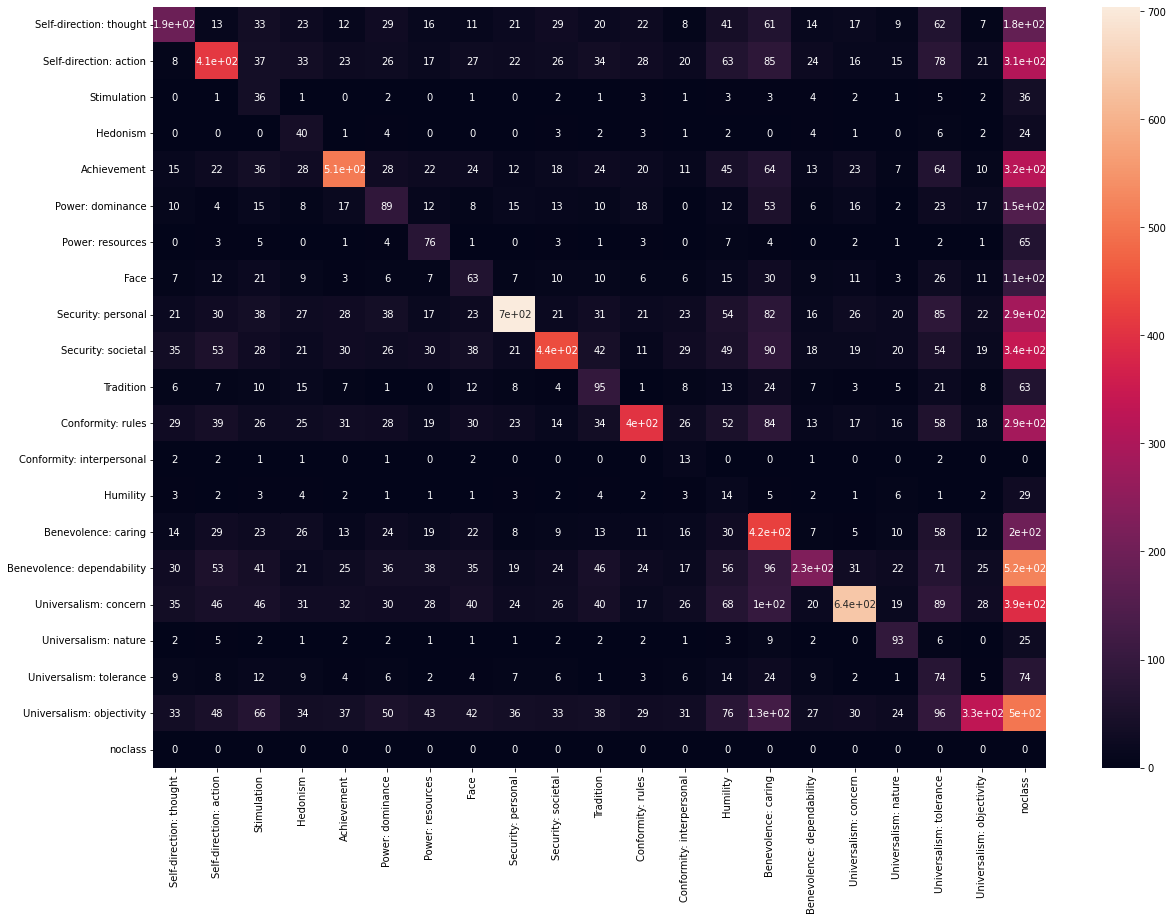

In [ ]:
from mlcm import mlcm
import seaborn as sn
import matplotlib.pyplot as plt

conf_mat,normal_conf_mat = mlcm.cm(predictions,targets)
df_cm = pd.DataFrame(conf_mat, index = [i for i in labels.append(pd.Index(['noclass']))],
                  columns = [i for i in labels.append(pd.Index(['noclass']))])
plt.figure(figsize = (20,14))
sn.heatmap(df_cm, annot=True)